In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_theme(style='white', context='notebook', font_scale=1.33)

## Section 1: Item Assembly

In [2]:
## Extract parameters.
params = read_csv('stan_results/3pl_summary.tsv', sep='\t', index_col=0)
beta  = params.T.filter(regex='beta\[').T['Mean'].values
alpha = params.T.filter(regex='alpha\[').T['Mean'].values

## Extract DIF. 
dif = read_csv('stan_results/dif.csv')
dif = np.repeat(np.where(dif.fwe2 < 0.05, 1, 0), 2)

## Extract IFS.
ifs = read_csv('stan_results/3pl_ifs.csv')
ifs = np.where(ifs.p >= 0.95, 1, 0)

## Define exclusions.
exclude = np.logical_or(dif, ifs).astype(int)

## 
items = np.arange(exclude.size)
items = items[exclude == 0]
beta  = beta[exclude == 0]
alpha = alpha[exclude == 0]
gamma = 0.25

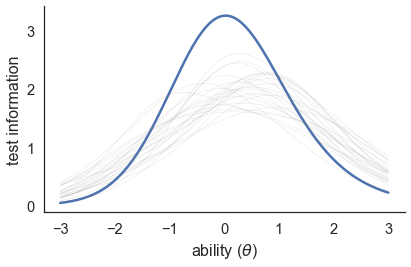

In [3]:
from scipy.stats import norm

def inv_logit(x):
    return 1 / (1 + np.exp(-x))

theta = np.linspace(-3,3,1001)
template = norm(0,1).pdf(theta)

mu = np.outer(theta, alpha) - beta
p = gamma + (1-gamma) * inv_logit(mu)
q = 1 - p

info = alpha**2 * (q / p) * np.square((p - gamma) / (1 - gamma))

include = []
for _ in range(12):
    
    ## Define index for remaining items.
    valid = include + [i - 1 if i % 2 else i + 1 for i in include]
    ix = np.setdiff1d(np.arange(items.size), valid)
    
    ## Compute potential TIF.
    tif = (info[:,include].sum(axis=1) + info[:,ix].T) @ template
    
    ## Identify maximum TIF.
    include.append(ix[np.argmax(tif)])

chosen = np.sort(items[include])
    
plt.plot(theta, info[:,include].sum(axis=1), lw=2.5)
plt.xlabel(r'ability ($\theta$)')
plt.ylabel('test information')

np.random.seed(47404)
for _ in range(25):
    plt.plot(theta, info[:,np.random.choice(np.arange(items.size), 12)].sum(axis=1), 
             lw=0.5, color='0.5', alpha=0.2)
    
sns.despine()
plt.tight_layout()

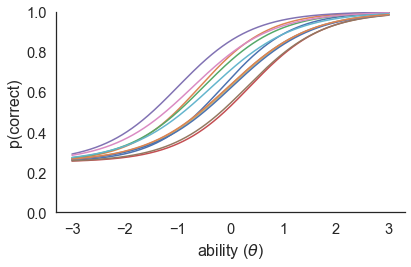

In [4]:
plt.plot(theta, p[:,include])
plt.xlabel(r'ability ($\theta$)')
plt.ylabel('p(correct)')
plt.ylim(0,1)

sns.despine()
plt.tight_layout()

In [5]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load data.
data = read_csv(os.path.join('data', 'data.csv'))

## Apply rejections.
reject = read_csv(os.path.join('data', 'reject.csv'))
data = data.loc[data.subject.isin(reject.query('reject==0').subject)]

## Re-index items.
data['item_id'] = data.apply(lambda x: '%0.2d' %x['item'] + '_' + x['distractor'], 1)
data['item_id'] = np.unique(data.item_id, return_inverse=True)[-1]

## Score missing data.
data['accuracy'] = data['accuracy'].fillna(0)

accuracy = data.groupby('item_id').accuracy.mean()

In [6]:
from pandas import DataFrame

df = DataFrame(dict(
    item_id = chosen, 
    accuracy = accuracy[chosen].values,
    beta = beta[include],
    alpha = alpha[include],
))

df = df.merge(data[['item_id','item','distractor']].drop_duplicates())
df = df[['item_id','item','distractor','accuracy','beta','alpha']]
df['item_id'] += 1

df.sort_values('accuracy', ascending=False)

,item_id,item,distractor,accuracy,beta,alpha
10,110,71,pd,0.791667,0.0321,1.31
8,82,55,pd,0.763441,-0.0164,1.31
5,44,30,pd,0.743842,0.4360,1.40
7,64,45,pd,0.724138,-0.0469,1.31
0,6,11,pd,0.704082,-0.2230,1.53
4,42,29,pd,0.700000,-1.4300,1.43
1,15,16,md,0.655738,-0.8950,1.53
2,18,17,pd,0.638298,-0.7230,1.41
3,29,23,md,0.631285,0.5240,1.45
9,85,58,md,0.623711,-0.4570,1.29


## Section 3: Recovery

100%|██████████| 1000/1000 [00:10<00:00, 98.39it/s]


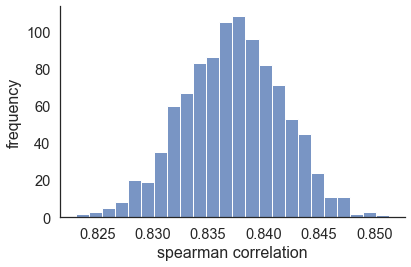

In [7]:
from scipy.stats import spearmanr
from tqdm import tqdm
np.random.seed(47404)

rho = np.zeros(1000)

for n in tqdm(range(rho.size)):

    theta = np.random.normal(0, 1, 5000)
    beta_s = beta[include]
    alpha_s = alpha[include]

    mu = np.outer(theta, alpha_s) - beta_s
    p = gamma + (1 - gamma) * inv_logit(mu)

    scores = np.random.binomial(1, p).sum(axis=1)
    rho[n], _ = spearmanr(theta, scores)
    
ax = sns.histplot(rho)
ax.set(xlabel='spearman correlation', ylabel='frequency')

sns.despine()
plt.tight_layout()

In [ ]:
from cmdstanpy import CmdStanModel
from scipy.stats import spearmanr
from tqdm import tqdm
np.random.seed(47404)

rho = np.zeros((50,2))

## Load StanModel
StanModel = CmdStanModel(stan_file=os.path.join('stan_models',f'3pl_map.stan'))

for n in tqdm(range(len(rho))):

    theta = np.random.normal(0, 1, 1500)
    beta_s = beta[include]
    alpha_s = alpha[include]

    mu = np.outer(theta, alpha_s) - beta_s
    p = gamma + (1 - gamma) * inv_logit(mu)
    Y = np.random.binomial(1, p)
    scores = Y.sum(axis=1)
    Y = Y.flatten()
    
    N = len(Y)
    J = np.repeat(np.arange(1500), 12) + 1
    K = np.tile(np.arange(12), 1500) + 1
    
    ## Assemble data.
    dd = dict(N=N, J=J, K=K, Y=Y, beta=beta_s, alpha=alpha_s)
    
    ## 
    StanFit = StanModel.optimize(data=dd, seed=0, sig_figs=6)
    
    theta_hat = StanFit.optimized_params_np[1:]
    
    rho[n,0], _ = spearmanr(theta, scores)
    rho[n,1], _ = spearmanr(theta, theta_hat)

In [ ]:
ax = sns.histplot(rho[:,0])
ax = sns.histplot(rho[:,1])
ax.set(xlabel='spearman correlation', ylabel='frequency')

sns.despine()
plt.tight_layout()

In [ ]:
rho[:,1] - rho[:,0]